## Tutorial : Img2Img with LORA


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


  0%|          | 0/37 [00:00<?, ?it/s]

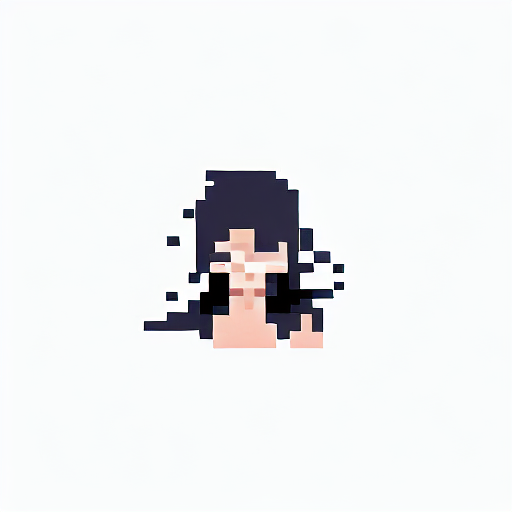

In [2]:
from diffusers import StableDiffusionImg2ImgPipeline
import torch
from PIL import Image


init_image = Image.open("/home/hyoju/바탕화면/hyohyo/test_img/test (4).png").convert("RGB").resize((512, 512))

model_id = "runwayml/stable-diffusion-v1-5"

pipe = StableDiffusionImg2ImgPipeline.from_pretrained(model_id, torch_dtype=torch.float16).to(
    "cuda"
)

prompt = "pixel character"
torch.manual_seed(1)
image = pipe(prompt=prompt, image=init_image, strength=0.75, guidance_scale=7.5).images[0]

image


In [6]:
!pip install -r '/home/hyoju/바탕화면/lora-master/requirements.txt'


In [8]:
import os

# 환경 변수 설정
os.environ['MODEL_NAME'] = "runwayml/stable-diffusion-v1-5"
os.environ['INSTANCE_DIR'] = "/home/hyoju/바탕화면/hyohyo/maple_data/output"
os.environ['OUTPUT_DIR'] = "/home/hyoju/바탕화면/hyohyo/g_output"

# LoRA 미세조정 명령어 실행
!lora_pti \
  --pretrained_model_name_or_path=$MODEL_NAME  \
  --instance_data_dir=$INSTANCE_DIR \
  --output_dir=$OUTPUT_DIR \
  --train_text_encoder \
  --resolution=512 \
  --train_batch_size=1 \
  --gradient_accumulation_steps=4 \
  --scale_lr \
  --learning_rate_unet=1e-4 \
  --learning_rate_text=1e-5 \
  --learning_rate_ti=5e-4 \
  --color_jitter \
  --lr_scheduler="linear" \
  --lr_warmup_steps=0 \
  --placeholder_tokens="<s1>|<s2>" \
  --use_template="style" \
  --save_steps=100 \
  --max_train_steps_ti=1000 \
  --max_train_steps_tuning=1000 \
  --perform_inversion=True \
  --clip_ti_decay \
  --weight_decay_ti=0.000 \
  --weight_decay_lora=0.001 \
  --continue_inversion \
  --continue_inversion_lr=1e-4 \
  --device="cuda:0" \
  --lora_rank=1

/home/hyoju/anaconda3/envs/ldm/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
PTI : Initializer Tokens not given, doing random inits
PTI : Placeholder Tokens ['<s1>', '<s2>']
PTI : Initializer Tokens ['<rand-0.017>', '<rand-0.017>']
Initialized <s1> with random noise (sigma=0.017), empirically -0.000 +- 0.017
Norm : 0.4722
Initialized <s2> with random noise (sigma=0.017), empirically 0.000 +- 0.017
Norm : 0.4585
/home/hyoju/바탕화면/diffusers-main/examples/dreambooth/diffusers/src/diffusers/configuration_utils.py:244: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a scheduler, please use <class 'diffusers.schedulers.scheduling_ddpm.DDPMScheduler'>.from_pretrained(...) instead. Otherwise, please make sure to pass a configuration dic

<s1>
The tokenizer already contains the token <s1>.
Replacing <s1> embedding.
<s2>
The tokenizer already contains the token <s2>.
Replacing <s2> embedding.


  0%|          | 0/37 [00:00<?, ?it/s]

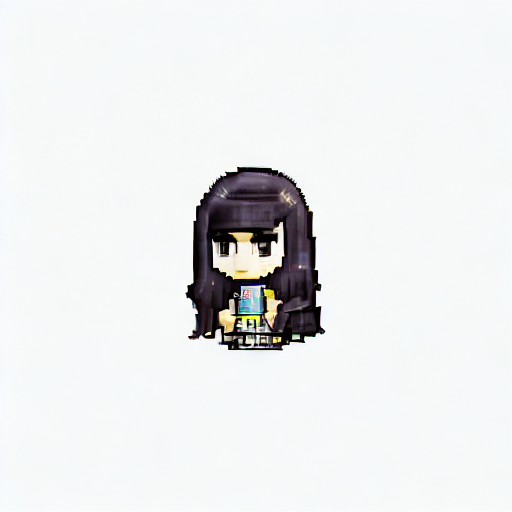

In [11]:
from lora_diffusion import patch_pipe, tune_lora_scale


patch_pipe(pipe, "/home/hyoju/바탕화면/hyohyo/g_output/final_lora.safetensors", patch_text=True, patch_unet=True, patch_ti=True)

#torch.manual_seed(1)
image = pipe(prompt=prompt, image=init_image, strength=0.75, guidance_scale=7.5).images[0]

image


#


  0%|          | 0/37 [00:00<?, ?it/s]

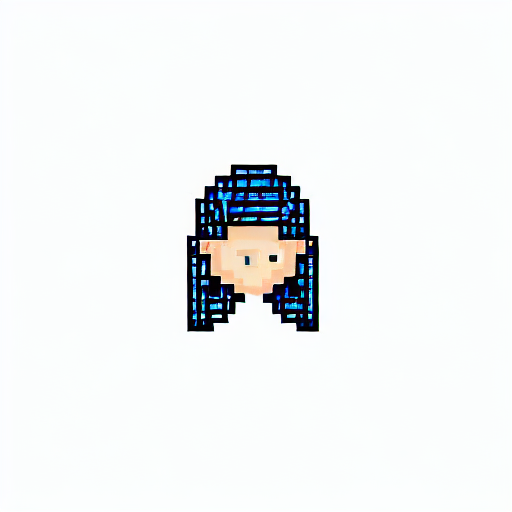

In [14]:
tune_lora_scale(pipe.unet, 0.0)
tune_lora_scale(pipe.text_encoder, 0.0)
# So just the latent inversion will have an effect :  
#torch.manual_seed(1)
image = pipe(prompt=prompt, image=init_image, strength=0.75, guidance_scale=7.5).images[0]

image

  0%|          | 0/37 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


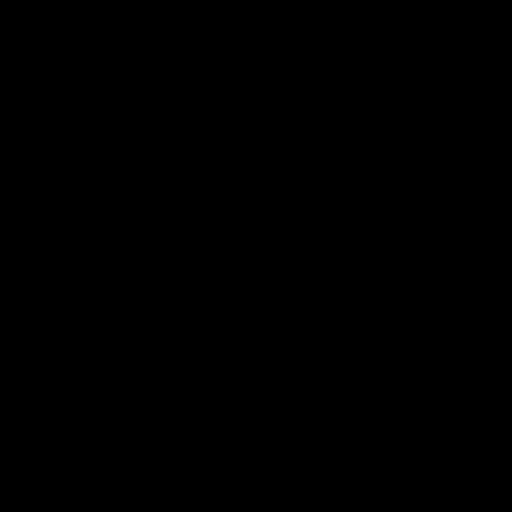

In [35]:
tune_lora_scale(pipe.unet, 0.7)
tune_lora_scale(pipe.text_encoder, 0.3)
# Something in the middle works ok
#torch.manual_seed(77)
image = pipe(prompt=prompt, image=init_image, strength=0.75, guidance_scale=7.5).images[0]

image